In [267]:
import numpy as np
import gym
from gym import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist

class customSpatialEnv(gym.Env):
    def __init__(self, octave: float, grid_size: tuple = (100, 100), tree_ratio=0.05, shrub_ratio=0.60, max_plants=50):
        super(customSpatialEnv, self).__init__()
        
        # Environment setup
        self.grid_size = grid_size
        self.octave = octave
        self.tree_ratio = tree_ratio
        self.shrub_ratio = shrub_ratio
        self.max_plants = max_plants  # Maximum plants per episode
        self.plants_placed = 0  # Counter for placed plants

        # Species details
        self.species_list = [
            {"name": "Oak", "type": "Tree", "shade_radius": 15},
            {"name": "Pine", "type": "Tree", "shade_radius": 10},
            {"name": "Birch", "type": "Tree", "shade_radius": 8},
            {"name": "Juniper", "type": "Shrub", "shade_tolerance": "full"},
            {"name": "Holly", "type": "Shrub", "shade_tolerance": "half"},
            {"name": "Lavender", "type": "Shrub", "shade_tolerance": "none"},
        ]
        
        # Initial grid and planting positions
        self.grid, self.planting_coordinates = self._create_environment()
        self.initial_grid = self._assign_initial_plants()
        self.final_grid = np.zeros_like(self.initial_grid)

        # Define action and observation spaces
        self.action_space = spaces.Discrete(len(self.species_list))
        self.observation_space = spaces.Box(low=0, high=2, shape=self.grid_size, dtype=np.int8)

    def _calculate_shade_levels(self):
        # Initialize the grid with no shade
        shade_grid = np.zeros(self.grid_size)
        
        # Loop over all tree coordinates to assign shade
        for coord in self.planting_coordinates:
            plant_type = self.initial_grid[coord[0], coord[1]]
            
            if plant_type == 1:  # Tree
                # Retrieve the specific tree species and its radius
                species_index = int(self.final_grid[coord[0], coord[1]] - 3)
                if 0 <= species_index < len(self.species_list):
                    tree_species = self.species_list[species_index]
                    radius = tree_species.get("shade_radius", 0)
                    
                    # Apply shade levels within the radius
                    for x in range(max(0, coord[0] - radius), min(self.grid_size[0], coord[0] + radius + 1)):
                        for y in range(max(0, coord[1] - radius), min(self.grid_size[1], coord[1] + radius + 1)):
                            # Calculate Euclidean distance from the tree center
                            distance = np.sqrt((coord[0] - x)**2 + (coord[1] - y)**2)
                            
                            # Determine shade level based on distance from tree center
                            if distance <= radius / 2:
                                shade_level = 2  # Full shade
                            elif distance <= radius:
                                shade_level = 1  # Half shade
                            else:
                                continue  # Outside the shade radius, skip further processing
                            
                            # Update the shade level only if the new level is higher
                            previous_shade = shade_grid[x, y]
                            shade_grid[x, y] = max(previous_shade, shade_level)
        
        return shade_grid

    def _create_environment(self):
        while True:
            noise = PerlinNoise(octaves=self.octave, seed=np.random.randint(0, 50))
            width, height = self.grid_size
            perlin_env = np.array([[noise([i / height, j / width]) for j in range(width)] for i in range(height)])
            dithered_perlin_env = self._dither_environment(perlin_env)
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())
            if planting_density > 7.5 / 100:
                break
        planting_grid, planting_coords = self._filter_environment(planting_positions)
        return planting_grid, planting_coords

    def _dither_environment(self, perlin_env):
        bayer_matrix = np.array([[0, 8, 2, 10], [12, 4, 14, 6], [3, 11, 1, 9], [15, 7, 13, 5]]) / 16.0
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size
        for y in range(height):
            for x in range(width):
                bayer_value = bayer_matrix[y % 4, x % 4]
                dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
        return dithered_grid

    def _filter_environment(self, planting_positions):
        min_distance = 10
        filtered_planting_positions = planting_positions.copy()
        distances = cdist(filtered_planting_positions, filtered_planting_positions)
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)
        for i in range(len(filtered_planting_positions)):
            if filtered_planting_positions[i][0] <= 5 or filtered_planting_positions[i][0] >= (self.grid_size[0] - 5) or \
               filtered_planting_positions[i][1] <= 5 or filtered_planting_positions[i][1] >= (self.grid_size[1] - 5):
                keep_array[i] = False
            if keep_array[i]:
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < min_distance:
                        keep_array[j] = False
        final_planting_coordinates = filtered_planting_positions[keep_array]
        final_grid = np.zeros(self.grid_size)
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates

    def _assign_initial_plants(self):
        initial_grid = self.grid.copy()
        num_tree_cells = int(len(self.planting_coordinates) * self.tree_ratio)
        num_shrub_cells = int(len(self.planting_coordinates) * self.shrub_ratio)
        planting_coordinates_tuples = [tuple(coord) for coord in self.planting_coordinates]
        tree_positions = random.sample(planting_coordinates_tuples, num_tree_cells)
        shrub_positions = random.sample(list(set(planting_coordinates_tuples) - set(tree_positions)), num_shrub_cells)
        
        # Initialize final_grid
        final_grid = np.zeros_like(initial_grid)
        
        # Get tree species list
        tree_species_list = [species for species in self.species_list if species['type'] == 'Tree']
        
        for position in tree_positions:
            initial_grid[position[0], position[1]] = 1  # Tree
            # Assign a random tree species
            tree_species = random.choice(tree_species_list)
            species_index = self.species_list.index(tree_species)
            final_grid[position[0], position[1]] = species_index + 3  # Store species index
        
        for position in shrub_positions:
            initial_grid[position[0], position[1]] = 2  # Shrub
            # Shrubs will be assigned species later
    
        self.final_grid = final_grid  # Update the final_grid with tree species
        return initial_grid

    def apply_planting(self):
        # Define a mapping for shade tolerances to shade levels
        shade_mapping = {"none": 0, "half": 1, "full": 2}
        
        # Calculate the shade levels for each grid cell and store in self.shade_grid
        self.shade_grid = self._calculate_shade_levels()
        
        # Loop through all planting coordinates to assign appropriate plants
        for coord in self.planting_coordinates:
            # Retrieve the initial plant type at the current coordinate (1 for Tree, 2 for Shrub)
            initial_plant_type = self.initial_grid[coord[0], coord[1]]
            
            # Determine the current shade level at this coordinate
            shade_level = int(self.shade_grid[coord[0], coord[1]])
            
            # Only proceed with planting shrubs, indicated by type 2
            if initial_plant_type == 2:  # Shrub
                print(f"Evaluating shrub planting at {coord} with shade level {shade_level}")
                
                # Find all shrub species that match the current shade level
                suitable_species = [
                    species for species in self.species_list 
                    if species["type"] == "Shrub" and
                    shade_level == shade_mapping.get(species.get("shade_tolerance", "none"), -1)
                ]
                # Output names of suitable species that match the shade level at this position
                print(f"Suitable species: {[s['name'] for s in suitable_species]}")
                
                # If there are suitable species that match the shade level, choose one randomly
                if suitable_species:
                    chosen_species = random.choice(suitable_species)  # Randomly select a suitable species
                    species_index = self.species_list.index(chosen_species)  # Get the species index in the species list
                    
                    # Update the final grid at this coordinate with the species index, offset by 3
                    self.final_grid[coord[0], coord[1]] = species_index + 3
                    print(f"Planted {chosen_species['name']} (tolerance: {chosen_species['shade_tolerance']}) at {coord} with shade level {shade_level}")
                else:
                    # If no suitable species match the shade level, log this info
                print(f"No suitable species found for location {coord} with shade level {shade_level}", flush=True)



    def _select_species_based_on_conditions(self, species_options, coord):
        plant_type = self.initial_grid[coord[0], coord[1]]
        cell_shade_level = self.shade_grid[coord[0], coord[1]]

        if plant_type == 1:
            return random.choice(species_options)
        else:
            preferred_species = [
                species for species in species_options
                if (species.get("shade_tolerance") == "full" and cell_shade_level == 2) or
                (species.get("shade_tolerance") == "half" and cell_shade_level == 1) or
                (species.get("shade_tolerance") == "none" and cell_shade_level == 0)
            ]
            return random.choice(preferred_species if preferred_species else species_options)

    def reset(self):
        self.final_grid = np.zeros_like(self.initial_grid)
        self.plants_placed = 0
        return self.initial_grid

    def step(self, action):
        coord = random.choice(self.planting_coordinates)
        initial_plant_type = self.initial_grid[coord[0], coord[1]]
        chosen_species = self.species_list[action]
        reward = 0

        if (chosen_species["type"] == "Tree" and initial_plant_type == 1) or \
           (chosen_species["type"] == "Shrub" and initial_plant_type == 2):
            reward += 10
        else:
            reward -= 5

        self.final_grid[coord[0], coord[1]] = self.species_list.index(chosen_species) + 3
        self.plants_placed += 1
        done = self.plants_placed >= self.max_plants or np.all(self.final_grid != 0)
        
        return self.final_grid, reward, done, {}

    def render(self, mode="human"):
        print(self.final_grid)

In [268]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

def visualize_initial_grid(grid):
    display_grid = np.zeros((grid.shape[0], grid.shape[1], 3))
    for x in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            if grid[x, y] == 1:
                display_grid[x, y] = (0.3, 0.6, 0.3)  # Green for Trees
            elif grid[x, y] == 2:
                display_grid[x, y] = (0.5, 0.3, 0.1)  # Brown for Shrubs
            else:
                display_grid[x, y] = (1, 1, 1)  # White for empty

    plt.imshow(display_grid, interpolation="nearest")
    plt.title("Initial Grid (Green=Tree, Brown=Shrub)")
    tree_patch = mpatches.Patch(color=(0.3, 0.6, 0.3), label="Tree")
    shrub_patch = mpatches.Patch(color=(0.5, 0.3, 0.1), label="Shrub")
    plt.legend(handles=[tree_patch, shrub_patch], loc='upper right')
    plt.show()


def visualize_final_grid(grid, species_list):
    """
    Visualize the final planting grid with different shades of green for trees
    and different shades of brown for shrubs.
    """
    # Define color lists for trees and shrubs
    tree_colors = ["#228B22", "#006400", "#32CD32"]  # Different shades of green
    shrub_colors = ["#8B4513", "#A0522D", "#D2B48C"]  # Different shades of brown

    # Prepare the display grid with color-coded plants
    display_grid = np.zeros((grid.shape[0], grid.shape[1], 3))  # RGB grid for color mapping
    
    for x in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            plant_type = int(grid[x, y])  # Ensure plant_type is an integer
            if plant_type >= 3:  # Plant species starts from index 3
                species_index = plant_type - 3
                species = species_list[species_index]
                
                # Assign colors based on plant type
                if species["type"] == "Tree":
                    display_grid[x, y] = mcolors.to_rgba(tree_colors[species_index % len(tree_colors)])[:3]
                elif species["type"] == "Shrub":
                    display_grid[x, y] = mcolors.to_rgba(shrub_colors[species_index % len(shrub_colors)])[:3]

    plt.imshow(display_grid, interpolation="nearest")

    # Create legend patches for trees and shrubs with corresponding species names
    tree_patches = [
        mpatches.Patch(color=tree_colors[i], label=f'{species_list[i]["name"]} (Tree)')
        for i in range(len(species_list)) if species_list[i]["type"] == "Tree"
    ]
    shrub_patches = [
        mpatches.Patch(color=shrub_colors[i % len(shrub_colors)], label=f'{species_list[i]["name"]} (Shrub)')
        for i in range(len(species_list)) if species_list[i]["type"] == "Shrub"
    ]

    # Add legend for trees and shrubs
    plt.legend(handles=tree_patches + shrub_patches, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.title("Final Planting Grid (Trees in Green, Shrubs in Brown)")
    plt.show()

def visualize_grid_with_radius(final_grid, species_list, grid_size, shade_grid):
    """
    Visualizes the planting grid with trees, shrubs, and shade radius around trees.
    Each shrub is labeled with its species name, shade level, and coordinates; trees are labeled with species name and coordinates only.
    
    Parameters:
    - final_grid: 2D numpy array representing the planted grid.
    - species_list: List of dictionaries with species information, including shade radius for trees.
    - grid_size: Tuple indicating the size of the grid (height, width).
    - shade_grid: 2D numpy array representing the shade level at each grid cell.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(-0.5, grid_size[1] - 0.5)  # Match x-axis with grid cells
    ax.set_ylim(-0.5, grid_size[0] - 0.5)  # Match y-axis with grid cells
    ax.set_aspect('equal')
    
    # Colors for different plants and radius shading
    tree_colors = ["#228B22", "#006400", "#32CD32"]  # Different shades of green for trees
    shrub_colors = ["#8B4513", "#A0522D", "#D2B48C"]  # Different shades of brown for shrubs
    shade_color = "lightgreen"  # Color for the tree shade radius

    # Loop through the grid and plot trees, shrubs, and their shade radius
    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            plant_type = final_grid[x, y]
            if plant_type >= 3:  # A planted species index
                species_index = int(plant_type) - 3  # Ensure integer for indexing
                species = species_list[species_index]
                plant_name = species["name"]

                # Determine the color based on the species type
                if species["type"] == "Tree":
                    color = mcolors.to_rgba(tree_colors[species_index % len(tree_colors)])[:3]
                    
                    # Plot the tree
                    ax.plot(y, x, 'o', color=color, markersize=8)
                    
                    # Plot the shade radius circle
                    radius = species.get("shade_radius", 0)
                    if radius > 0:
                        shade_circle = patches.Circle(
                            (y, x), radius, color=shade_color, alpha=0.4, edgecolor="none"
                        )
                        ax.add_patch(shade_circle)

                    # Label the tree with its species name and coordinates
                    ax.text(y, x, f"{plant_name} ({x},{y})", ha='center', va='center',
                            fontsize=6, color='black', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

                elif species["type"] == "Shrub":
                    color = mcolors.to_rgba(shrub_colors[species_index % len(shrub_colors)])[:3]
                    # Plot the shrub
                    ax.plot(y, x, 's', color=color, markersize=6)
                
                    # Determine and display the shade level (Full, Half, None)
                    shade_level = shade_grid[x, y]
                    if shade_level == 2:
                        shade_text = "Full Shade"
                    elif shade_level == 1:
                        shade_text = "Half Shade"
                    else:
                        shade_text = "No Shade"
                    
                    # Add shrub name, shade level, and coordinates as a label
                    ax.text(y, x, f"{plant_name}\n{shade_text}\n({x},{y})", ha='center', va='center',
                            fontsize=6, color='black', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    # Invert y-axis to match orientation with other grid displays
    ax.invert_yaxis()

    # Add grid and labels
    plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
    plt.title("Planting Grid with Tree Shade Radius and Labels")
    plt.xlabel("Grid X")
    plt.ylabel("Grid Y")
    plt.show()





In [269]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback

def train_model(env, timesteps=10000, model_save_path="plant_selection_model_new3"):
    model = PPO("MlpPolicy", env, verbose=1)
    checkpoint_callback = CheckpointCallback(save_freq=1000, save_path="./", name_prefix="ppo_checkpoint")
    model.learn(total_timesteps=timesteps, callback=checkpoint_callback)
    model.save(model_save_path)
    return model


In [270]:
from stable_baselines3 import PPO

def load_model(model_path="plant_selection_model_new3"):
    return PPO.load(model_path)

def run_trained_model(env, model):
    obs = env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(action)
    env.apply_planting()  # Finalize planting after actions are chosen
    env.render()


In [271]:
env = customSpatialEnv(octave=1.5, grid_size=(100, 100))
trained_model = train_model(env, timesteps=10000)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\Admin\anaconda3\envs\py311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 119      |
| time/              |          |
|    fps             | 787      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 569         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009577193 |
|    clip_fraction        | 0.073       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.79       |
|    explained_variance   | 0.010906637 |
|    learning_rate        | 0.

Evaluating shrub planting at [ 6 70] with shade level 0
Suitable species: ['Lavender']
Planted Lavender (tolerance: none) at [ 6 70] with shade level 0
Evaluating shrub planting at [ 8 60] with shade level 0
Suitable species: ['Lavender']
Planted Lavender (tolerance: none) at [ 8 60] with shade level 0
Evaluating shrub planting at [14 76] with shade level 0
Suitable species: ['Lavender']
Planted Lavender (tolerance: none) at [14 76] with shade level 0
Evaluating shrub planting at [16 28] with shade level 0
Suitable species: ['Lavender']
Planted Lavender (tolerance: none) at [16 28] with shade level 0
Evaluating shrub planting at [16 40] with shade level 0
Suitable species: ['Lavender']
Planted Lavender (tolerance: none) at [16 40] with shade level 0
Evaluating shrub planting at [24 34] with shade level 0
Suitable species: ['Lavender']
Planted Lavender (tolerance: none) at [24 34] with shade level 0
Evaluating shrub planting at [24 72] with shade level 0
Suitable species: ['Lavender']
P

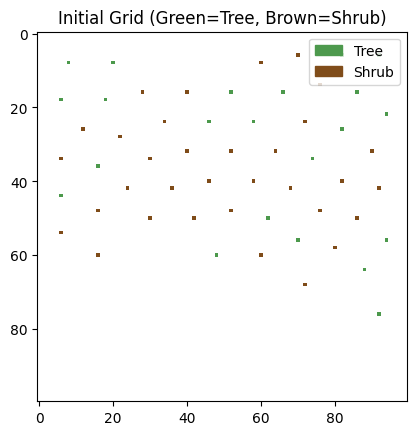

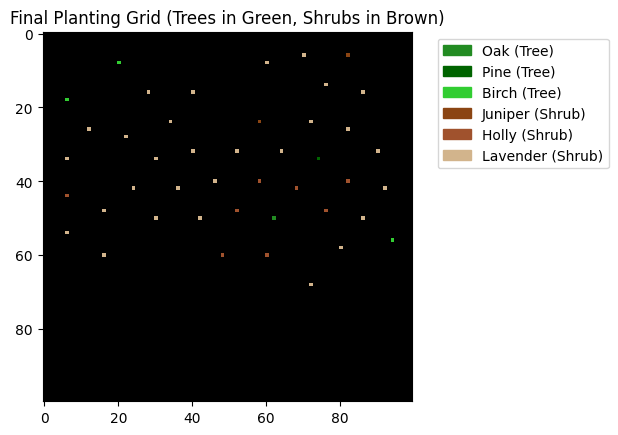

C:\Users\Admin\AppData\Local\Temp\ipykernel_28420\3748621403.py:107: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  shade_circle = patches.Circle(


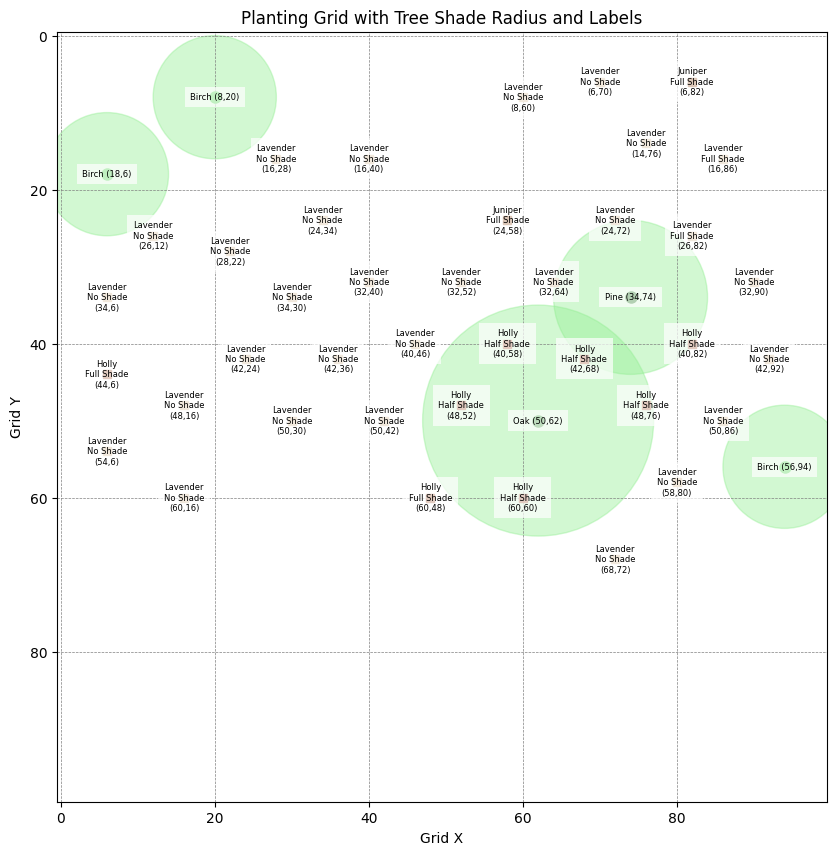

In [272]:
env = customSpatialEnv(octave=1.5, grid_size=(100, 100))
model = load_model("plant_selection_model_new3")
run_trained_model(env, model)
visualize_initial_grid(env.initial_grid)
visualize_final_grid(env.final_grid, env.species_list)
visualize_grid_with_radius(env.final_grid, env.species_list, env.grid_size, env.shade_grid)